https://catalog.data.gov/dataset/wastewater-treatment-plants

Let's analyze a dataset related to wastewater treatment plants and assess design hydraulic flow throughout the state of New York.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# import and take a look at the dataset
df = pd.read_csv("Wastewater_Treatment_Plants.csv")
df.head()

,Plant Type,SPDES Permit Number,Facility Name,Ground or Surface,Average Design Hydraulic Flow,Street,City,State,Country,Zip Code,Latitude,Longitude,Location 1
0,Industrial,NY0267708,NYC DOT - CITYWIDE BRIDGE SUMP PUMP DISCHARGES,Surface,NaN,CITYWIDE,NEW YORK CITY,NY,USA,NaN,NaN,NaN,NaN
1,Industrial,NY0276758,CORNELL NYCTECH CAMPUS - BLOOMBERG CENTER,Surface,NaN,1 MAIN ST|SOUTHERN ROOSEVELT ISLAND,NEW YORK,NY,USA,10044.0,40.75,-73.96,"(40.75, -73.96)"
2,Industrial,NY0277037,QBDK Huron LLC Prop - 1 Huron St,NaN,NaN,1 Huron St,Brooklyn,NY,USA,11222.0,40.73,-73.96,"(40.73, -73.96)"
3,Municipal,NY0020559,WEEDSPORT (V) WWTP,Surface,0.55,2601 EARL ST,WEEDSPORT,NY,USA,13166.0,43.05,-76.57,"(43.05, -76.57)"
4,Industrial,NY0225282,BROOKHAVEN COMBUSTION TURBINE,Ground,0.00,N COUNTRY RD|SCTM #200-39-1-1,WADING RIVER,NY,USA,11792.0,40.96,-72.88,"(40.96, -72.88)"


Let's go through each column to ensure they're clean.

In [3]:
# Loop through each column to find missing values
for column in df.columns:
    missing_values = df[column].isna().sum()
    print(f'Missing values in {column}: {missing_values}')

Missing values in Plant Type: 0
Missing values in SPDES Permit Number: 0
Missing values in Facility Name: 0
Missing values in Ground or Surface: 8
Missing values in Average Design Hydraulic Flow: 445
Missing values in Street: 0
Missing values in City: 0
Missing values in State: 0
Missing values in Country: 0
Missing values in Zip Code: 174
Missing values in Latitude: 5
Missing values in Longitude: 5
Missing values in Location 1: 5


In [4]:
# Check the proportion of 'Ground' vs 'Surface' in each state
df.groupby('Plant Type')['Ground or Surface'].value_counts(normalize=True)

Plant Type  Ground or Surface
Industrial  Surface              0.713974
            Ground               0.265648
            Both                 0.020378
Municipal   Surface              0.930599
            Ground               0.066246
            Both                 0.003155
Name: Ground or Surface, dtype: float64

In [5]:
# Define a function to replace missing values based on the majority class for each Plant Type
def fill_majority_class(row):
    if pd.isna(row['Ground or Surface']):
        # Find the majority class for the corresponding Plant Type
        majority_class = df[df['Plant Type'] == row['Plant Type']]['Ground or Surface'].mode()[0]
        return majority_class
    else:
        return row['Ground or Surface']

# Apply the function to fill missing values
df['Ground or Surface'] = df.apply(fill_majority_class, axis=1)

# Verify if missing values are replaced
print(df['Ground or Surface'].isna().sum())


0


Unfortunatley the 445 missing values for average design hydraulic flow will be difficult without more information related flow through a pipe, such as pipe dimensions. Perhaps it's best to visualize the distribution of values.

In [6]:
# Calculate the percentage of missing values
percentage_missing = (df['Average Design Hydraulic Flow'].isna().sum() / df.shape[0]) * 100

# Print the result
print(f"Percentage of missing values in 'Average Design Hydraulic Flow': {percentage_missing:.2f}%")


Percentage of missing values in 'Average Design Hydraulic Flow': 22.07%


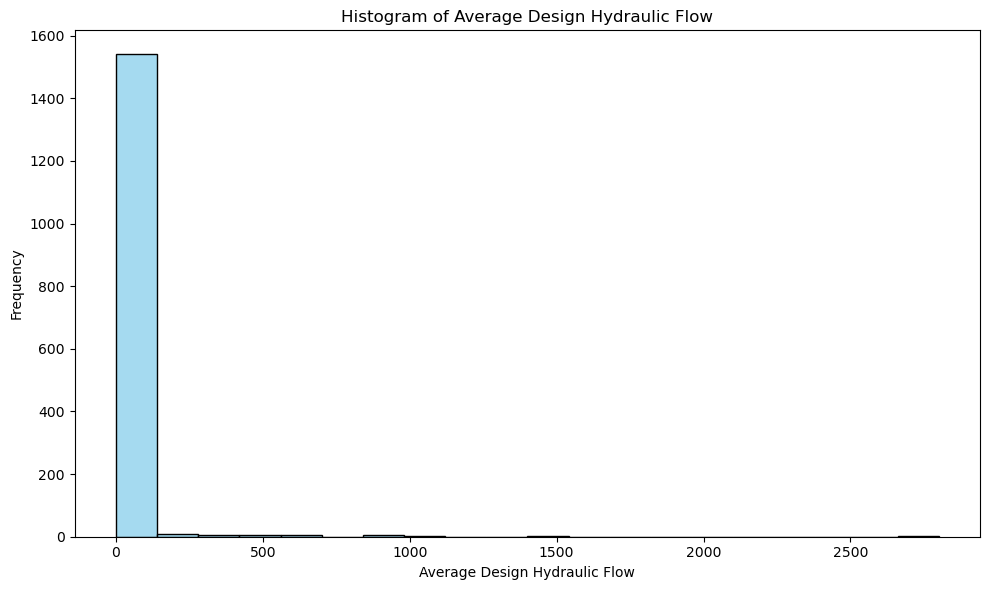

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram to visualize the distribution of values
plt.figure(figsize=(10, 6))
sns.histplot(df['Average Design Hydraulic Flow'].dropna(), bins=20, color='skyblue')

# Set titles and labels
plt.title('Histogram of Average Design Hydraulic Flow')
plt.xlabel('Average Design Hydraulic Flow')
plt.ylabel('Frequency')



# Show the plot
plt.tight_layout()
plt.show()



Therefore, we are going to replace it with the mode value.

In [8]:
# Calculate the mode of 'Average Design Hydraulic Flow'
mode_value = df['Average Design Hydraulic Flow'].mode().values[0]
mode_value

0.0

In [9]:
# Replace missing values with the mode
df['Average Design Hydraulic Flow'].fillna(mode_value, inplace=True)

# Verify that missing values have been filled
print(f"Missing values after filling: {df['Average Design Hydraulic Flow'].isna().sum()}")

Missing values after filling: 0


Looks like there are still some issues.

In [10]:
df['Average Design Hydraulic Flow'].values

array([0.  , 0.  , 0.  , ..., 0.04, 0.08, 0.01])

And with the zip code, it would be innacurate to fill these with the "mean" or some other statistic. We would need to look up each plant and manually fill these in, or find these in a database elsewhere. For the sake of this analysis, I will drop these as it's only a small subset of the data.

In [11]:
df = df.dropna(subset=['Zip Code'])

# Verify the result
print(f'Number of rows after dropping: {df.shape[0]}')
print(f'Number of missing values in Zip Code: {df["Zip Code"].isna().sum()}')


Number of rows after dropping: 1842
Number of missing values in Zip Code: 0


We need the actual verified values of lattitute and longitude as well. Since there are only 5, we'll just drop these.

In [12]:
df = df.dropna(subset=['Location 1'])

# Verify the result
print(f'Number of rows after dropping: {df.shape[0]}')
print(f'Number of missing values in Location: {df["Location 1"].isna().sum()}')

Number of rows after dropping: 1840
Number of missing values in Location: 0


In [13]:
# Loop through each column to find missing values
for column in df.columns:
    missing_values = df[column].isna().sum()
    print(f'Missing values in {column}: {missing_values}')

Missing values in Plant Type: 0
Missing values in SPDES Permit Number: 0
Missing values in Facility Name: 0
Missing values in Ground or Surface: 0
Missing values in Average Design Hydraulic Flow: 0
Missing values in Street: 0
Missing values in City: 0
Missing values in State: 0
Missing values in Country: 0
Missing values in Zip Code: 0
Missing values in Latitude: 0
Missing values in Longitude: 0
Missing values in Location 1: 0


Let's do some data visualizations to see if we can find anything interesting.

In [14]:
import geopandas as gpd

# Convert to GeoDataFrame
geometry = gpd.points_from_xy(df['Longitude'], df['Latitude'])
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Set the coordinate reference system (CRS) to WGS84
geo_df.set_crs(epsg=4326, inplace=True)

,Plant Type,SPDES Permit Number,Facility Name,Ground or Surface,Average Design Hydraulic Flow,Street,City,State,Country,Zip Code,Latitude,Longitude,Location 1,geometry
1,Industrial,NY0276758,CORNELL NYCTECH CAMPUS - BLOOMBERG CENTER,Surface,0.00,1 MAIN ST|SOUTHERN ROOSEVELT ISLAND,NEW YORK,NY,USA,10044.0,40.75,-73.96,"(40.75, -73.96)",POINT (-73.96000 40.75000)
2,Industrial,NY0277037,QBDK Huron LLC Prop - 1 Huron St,Surface,0.00,1 Huron St,Brooklyn,NY,USA,11222.0,40.73,-73.96,"(40.73, -73.96)",POINT (-73.96000 40.73000)
3,Municipal,NY0020559,WEEDSPORT (V) WWTP,Surface,0.55,2601 EARL ST,WEEDSPORT,NY,USA,13166.0,43.05,-76.57,"(43.05, -76.57)",POINT (-76.57000 43.05000)
4,Industrial,NY0225282,BROOKHAVEN COMBUSTION TURBINE,Ground,0.00,N COUNTRY RD|SCTM #200-39-1-1,WADING RIVER,NY,USA,11792.0,40.96,-72.88,"(40.96, -72.88)",POINT (-72.88000 40.96000)
5,Industrial,NY0251992,NYSDOT MAINTENANCE SUBHEADQUARTERS - WHITEHALL,Surface,0.00,RTE 4 & 22,WHITEHALL,NY,USA,12887.0,43.53,-73.41,"(43.53, -73.41)",POINT (-73.41000 43.53000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010,Industrial,NY0251305,ASHOKAN RESERVOIR,Both,0.00,2389 ST RTE 28A,SHOKAN,NY,USA,12481.0,41.97,-74.19,"(41.97, -74.19)",POINT (-74.19000 41.97000)
2011,Industrial,NY0003867,GMMM JENNISON LLC,Surface,65.34,BAINBRIDGE AFTON RD (ST RTE 7) - E SIDE,BAINBRIDGE,NY,USA,13733.0,42.28,-75.48,"(42.28, -75.48)",POINT (-75.48000 42.28000)
2013,Municipal,NY0020931,DEFERIET SEWAGE TREATMENT PLANT,Surface,0.04,126 RIVERSIDE DR,DEFERIET,NY,USA,13628.0,44.04,-75.68,"(44.04, -75.68)",POINT (-75.68000 44.04000)
2014,Municipal,NY0160971,BYRON SD STP,Surface,0.08,ST RTE 237 - W SIDE - OPPOSITE MILL POND RD,BYRON,NY,USA,14422.0,43.08,-78.07,"(43.08, -78.07)",POINT (-78.07000 43.08000)


Let's visualize the locations of the plants.

<Figure size 1000x800 with 0 Axes>

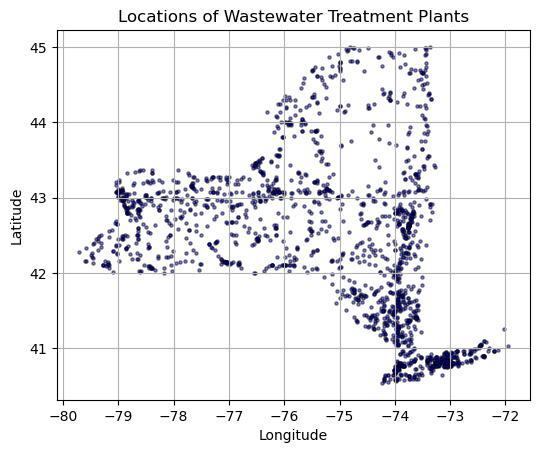

In [15]:
# Plot the locations
plt.figure(figsize=(10, 8))
base = geo_df.plot(color='blue', markersize=5, alpha=0.5, edgecolor='k')
plt.title('Locations of Wastewater Treatment Plants')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()


Nothing really interesting. Let's visualize the flow rates on top of this.

<Figure size 1000x800 with 0 Axes>

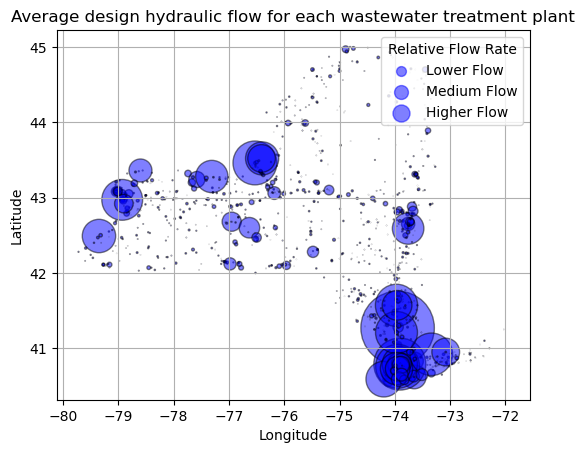

In [16]:
size_factor = 1  # Adjust this factor to scale the marker sizes
geo_df['Marker Size'] = geo_df['Average Design Hydraulic Flow'] * size_factor

# Create the plot
plt.figure(figsize=(10, 8))
base = geo_df.plot(
    color='blue', 
    markersize=geo_df['Marker Size'], 
    alpha=0.5, 
    edgecolor='k'
)

# Add title and labels
plt.title('Average design hydraulic flow for each wastewater treatment plant')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

# Create a custom legend
size_legend = [50, 100, 150]  # Tweak as needed

# Not actually calculated, this is for relative visualization purposes
labels = ['Lower Flow', 'Medium Flow', 'Higher Flow']
for size, label in zip(size_legend, labels):
    plt.scatter([], [], s=size, color='blue', alpha=0.5, label=label)

plt.legend(title="Relative Flow Rate", loc="upper right")

# Show the plot
plt.show()


Average design hydraulic flow tends to be higher in the southeast and northwest.

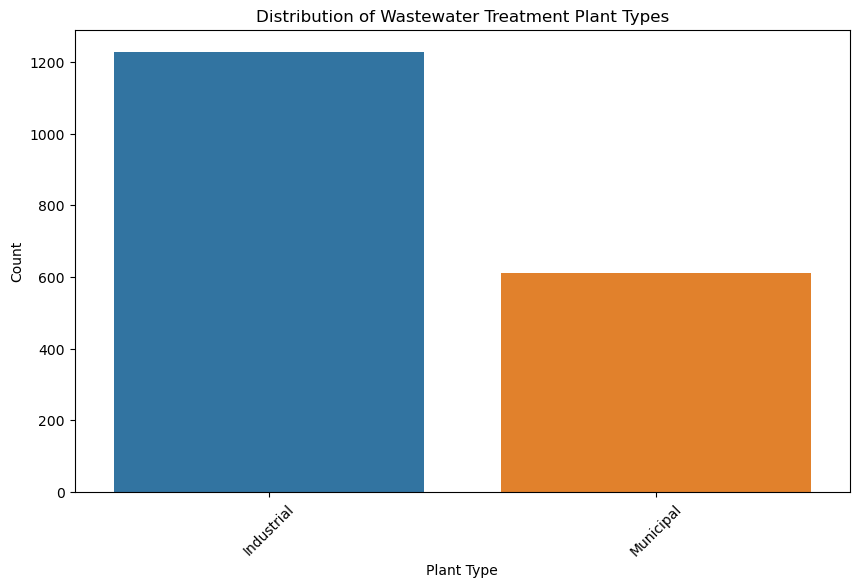

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Plant Type', order=df['Plant Type'].value_counts().index)
plt.title('Distribution of Wastewater Treatment Plant Types')
plt.xlabel('Plant Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Flow rate analysis by plant type?

<Figure size 1000x800 with 0 Axes>

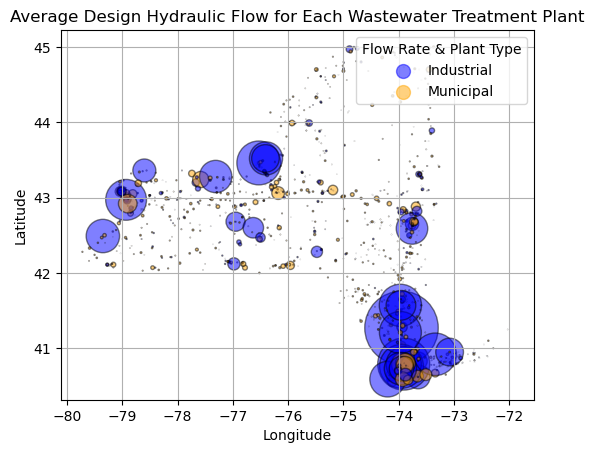

In [18]:
size_factor = 1  # Adjust this factor to scale the marker sizes
geo_df['Marker Size'] = geo_df['Average Design Hydraulic Flow'] * size_factor

# Create the plot
plt.figure(figsize=(10, 8))

# Create a color map for plant types
color_map = {
    'Industrial': 'blue',
    'Municipal': 'orange'
}

# Map colors to the plant types
geo_df['Color'] = geo_df['Plant Type'].map(color_map)

# Plot the locations with sizes based on flow rates and colors based on plant type
base = geo_df.plot(
    color=geo_df['Color'],
    markersize=geo_df['Marker Size'],
    alpha=0.5,
    edgecolor='k'
)

# Add title and labels
plt.title('Average Design Hydraulic Flow for Each Wastewater Treatment Plant')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

# Create a separate legend for plant types
plt.scatter([], [], s=100, color='blue', label='Industrial', alpha=0.5)
plt.scatter([], [], s=100, color='orange', label='Municipal', alpha=0.5)

plt.legend(title="Flow Rate & Plant Type", loc="upper right")

# Show the plot
plt.show()


What we have seen is that at least in New York, as expected, hyrdaulic flow is higher on average for industrial plants compared to municipal plants. In addition, the highest flow for both, and especially industrial, tends to be in the northwestern and southeastern parts of the state. 

However one thing seems peculiar and probably obvious: The higher flow rates are likely correlated with population.

In [19]:
pop_df = pd.read_csv("us-cities-table.csv")
pop_df.head()

,population,pop2024,pop2023,pop2022,pop2020,pop2010,growth,region,city,usps,state,countyFips,county,densityMi,slug,areaMi,lng,lat,type,rank
0,8097282,8097282,8258035,8335798,8740292,8190105,-0.01947,Southeast,New York City,NY,New York,36061|36085|36005|36119|36059|36081|36047,New York County,26950,new-york/new-york,300.457,-73.9387,40.6627,City,1
1,783355,783355,785678,788001,790387,760725,-0.00296,NaN,Hempstead,NY,New York,36059,Nassau County,6610,new-york/hempstead,118.514,-73.6091,40.6340,Town,2
2,487160,487160,488338,489516,484578,486735,-0.00241,NaN,Brookhaven,NY,New York,36103,Suffolk County,1876,new-york/brookhaven,259.645,-72.9598,40.8574,Town,3
3,335258,335258,336822,338386,339077,335540,-0.00464,NaN,Islip,NY,New York,36103,Suffolk County,3249,new-york/islip,103.199,-73.1952,40.7150,Town,4
4,297155,297155,297782,298409,300272,293990,-0.00211,NaN,Oyster Bay,NY,New York,36059,Nassau County,2868,new-york/oyster-bay,103.610,-73.5106,40.8005,Town,5


Quick cleaning is obviously needed.

<Figure size 1000x800 with 0 Axes>

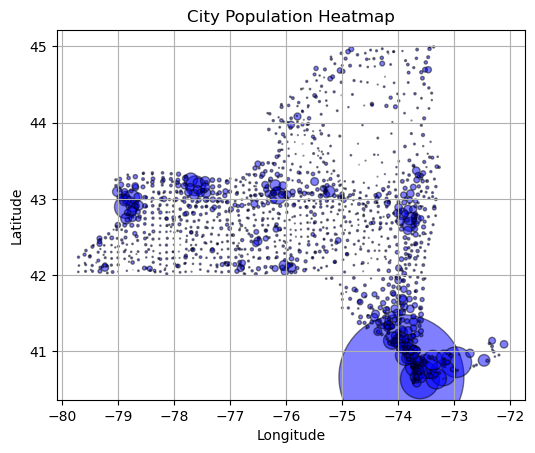

In [20]:
# Create a GeoDataFrame from the population DataFrame using latitude and longitude
geo_pop_df = gpd.GeoDataFrame(
    pop_df, 
    geometry=gpd.points_from_xy(pop_df['lng'], pop_df['lat']),
    crs="EPSG:4326"  # Coordinate reference system for lat/lng
)

# Set a size factor based on population
size_factor = 0.001  # Adjust this factor to scale the marker sizes appropriately
geo_pop_df['Marker Size'] = geo_pop_df['population'] * size_factor

# Create the plot
plt.figure(figsize=(10, 8))

# Plot the locations with sizes based on population
base = geo_pop_df.plot(
    color='blue', 
    markersize=geo_pop_df['Marker Size'], 
    alpha=0.5, 
    edgecolor='k'
)

# Add title and labels
plt.title('City Population Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()




# Show the plot
plt.show()


Indeed now we can see higher populations indicate a higher hydraulic flow. 

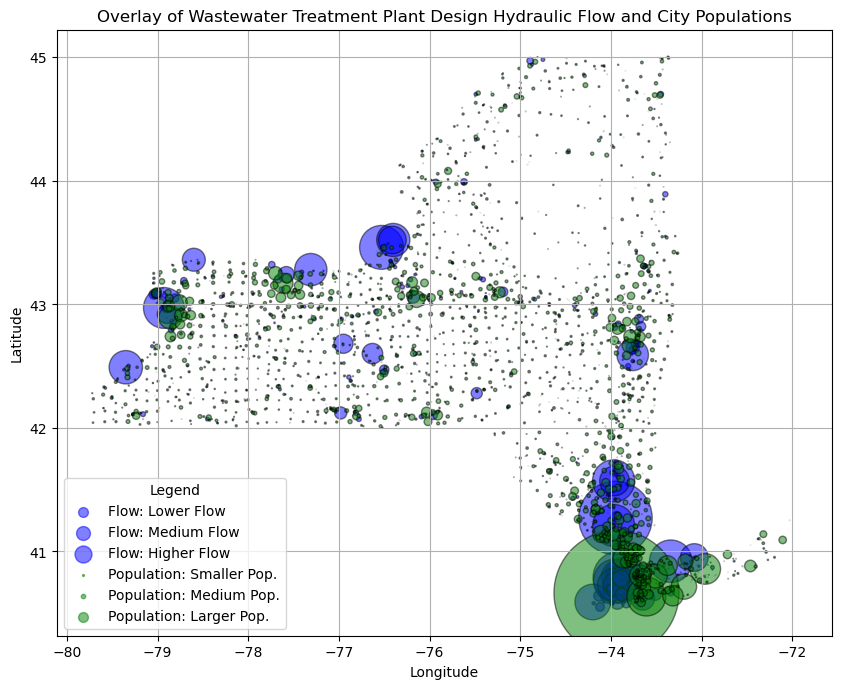

In [21]:
# Set size factors based on population and hydraulic flow
flow_size_factor = 1  # Adjust this factor to scale wastewater treatment marker sizes
pop_size_factor = 0.001  # Adjust this factor to scale population marker sizes

# Create marker sizes for both datasets
geo_df['Marker Size'] = geo_df['Average Design Hydraulic Flow'] * flow_size_factor
geo_pop_df['Marker Size'] = geo_pop_df['population'] * pop_size_factor

# Plot the figure
plt.figure(figsize=(10, 8))

# Plot the wastewater treatment plants with marker size based on hydraulic flow
geo_df.plot(
    ax=plt.gca(),
    color='blue', 
    markersize=geo_df['Marker Size'], 
    alpha=0.5, 
    edgecolor='k',
)

# Plot the city populations with marker size based on population
geo_pop_df.plot(
    ax=plt.gca(),
    color='green', 
    markersize=geo_pop_df['Marker Size'], 
    alpha=0.5, 
    edgecolor='k',
)

# Add title and labels
plt.title('Overlay of Wastewater Treatment Plant Design Hydraulic Flow and City Populations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

# Create a custom legend for both
# Wastewater Treatment Plants Legend
size_legend_flow = [50, 100, 150]  # Customize as needed for flow
labels_flow = ['Lower Flow', 'Medium Flow', 'Higher Flow']
for size, label in zip(size_legend_flow, labels_flow):
    plt.scatter([], [], s=size, color='blue', alpha=0.5, label=f'Flow: {label}')

# City Population Legend
size_legend_pop = [2000, 10000, 50000]  # Customize as needed for population
labels_pop = ['Smaller Pop.', 'Medium Pop.', 'Larger Pop.']
for size, label in zip(size_legend_pop, labels_pop):
    plt.scatter([], [], s=size * pop_size_factor, color='green', alpha=0.5, label=f'Population: {label}')

plt.legend(title="Legend", loc="lower left")

# Show the plot
plt.show()


However, both data sets don't exactly match with their cities. Let's ensure we only plot the cities that are in common.

In [22]:
# Convert both city columns to lowercase for accurate matching
pop_df['city'] = pop_df['city'].str.lower()
geo_df['City'] = geo_df['City'].str.lower()

# Merge the datasets on the city column
merged_df = pd.merge(geo_df, pop_df, left_on='City', right_on='city')
merged_df.head()


,Plant Type,SPDES Permit Number,Facility Name,Ground or Surface,Average Design Hydraulic Flow,Street,City,State,Country,Zip Code,...,state,countyFips,county,densityMi,slug,areaMi,lng,lat,type,rank
0,Municipal,NY0020559,WEEDSPORT (V) WWTP,Surface,0.55,2601 EARL ST,weedsport,NY,USA,13166.0,...,New York,36011|36067,Cayuga County,1797,new-york/weedsport,0.976,-76.5636,43.0481,Village,961
1,Industrial,NY0251992,NYSDOT MAINTENANCE SUBHEADQUARTERS - WHITEHALL,Surface,0.00,RTE 4 & 22,whitehall,NY,USA,12887.0,...,New York,36115,Washington County,70,new-york/whitehall,57.160,-73.3851,43.5391,Town,551
2,Industrial,NY0251992,NYSDOT MAINTENANCE SUBHEADQUARTERS - WHITEHALL,Surface,0.00,RTE 4 & 22,whitehall,NY,USA,12887.0,...,New York,36115,Washington County,439,new-york/whitehall,5.639,-73.4338,43.5460,Village,771
3,Municipal,NY0024929,WHITEHALL STP,Surface,1.70,RIVERSIDE DR,whitehall,NY,USA,12887.0,...,New York,36115,Washington County,70,new-york/whitehall,57.160,-73.3851,43.5391,Town,551
4,Municipal,NY0024929,WHITEHALL STP,Surface,1.70,RIVERSIDE DR,whitehall,NY,USA,12887.0,...,New York,36115,Washington County,439,new-york/whitehall,5.639,-73.4338,43.5460,Village,771


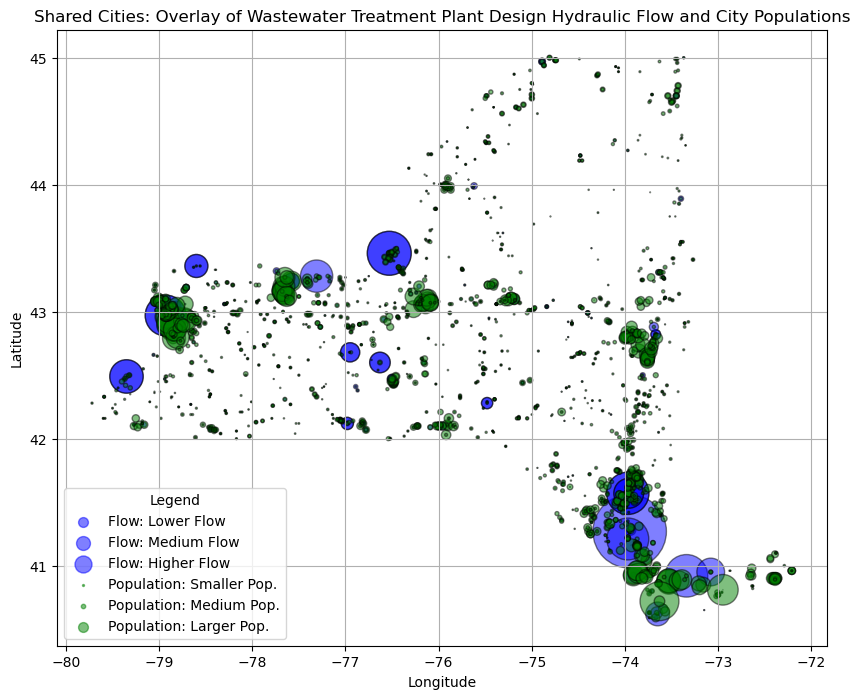

In [23]:
# Set size factors based on population and hydraulic flow
flow_size_factor = 1  # Adjust this factor to scale wastewater treatment marker sizes
pop_size_factor = 0.001  # Adjust this factor to scale population marker sizes

# Create marker sizes for the merged DataFrame
merged_df['Flow Marker Size'] = merged_df['Average Design Hydraulic Flow'] * flow_size_factor
merged_df['Pop Marker Size'] = merged_df['population'] * pop_size_factor

# Plot the figure
plt.figure(figsize=(10, 8))

# Plot the wastewater treatment plants with marker size based on hydraulic flow
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')
merged_gdf.plot(
    ax=plt.gca(),
    color='blue', 
    markersize=merged_df['Flow Marker Size'], 
    alpha=0.5, 
    edgecolor='k',
)

# Plot the city populations with marker size based on population
merged_gdf.plot(
    ax=plt.gca(),
    color='green', 
    markersize=merged_df['Pop Marker Size'], 
    alpha=0.5, 
    edgecolor='k',
)

# Add title and labels
plt.title('Shared Cities: Overlay of Wastewater Treatment Plant Design Hydraulic Flow and City Populations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

# Create a unified legend size scale for both datasets
legend_marker_sizes = [50, 100, 150]  # Sizes for the legend markers

# Create a custom legend for both
# Wastewater Treatment Plants Legend
size_legend_flow = [50, 100, 150]  # Customize as needed for flow
labels_flow = ['Lower Flow', 'Medium Flow', 'Higher Flow']
for size, label in zip(size_legend_flow, labels_flow):
    plt.scatter([], [], s=size, color='blue', alpha=0.5, label=f'Flow: {label}')

# City Population Legend
size_legend_pop = [2000, 10000, 50000]  # Customize as needed for population
labels_pop = ['Smaller Pop.', 'Medium Pop.', 'Larger Pop.']
for size, label in zip(size_legend_pop, labels_pop):
    plt.scatter([], [], s=size * pop_size_factor, color='green', alpha=0.5, label=f'Population: {label}')

# Add a unified legend
plt.legend(title="Legend", loc="lower left")

# Show the plot
plt.show()


There's still something that may be misleading about this; the scales are off for each. Let's normalize the population and flow columns.

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Select the columns to normalize
columns_to_normalize = ['Average Design Hydraulic Flow', 'population']

# Normalize the selected columns
normalized_values = scaler.fit_transform(merged_df[columns_to_normalize])

# Create new columns for the normalized values
merged_df['Normalized Average Design Hydraulic Flow'] = normalized_values[:, 0]
merged_df['Normalized Population'] = normalized_values[:, 1]

# Display the first few rows of the updated DataFrame
merged_df.head()



,Plant Type,SPDES Permit Number,Facility Name,Ground or Surface,Average Design Hydraulic Flow,Street,City,State,Country,Zip Code,...,slug,areaMi,lng,lat,type,rank,Flow Marker Size,Pop Marker Size,Normalized Average Design Hydraulic Flow,Normalized Population
0,Municipal,NY0020559,WEEDSPORT (V) WWTP,Surface,0.55,2601 EARL ST,weedsport,NY,USA,13166.0,...,new-york/weedsport,0.976,-76.5636,43.0481,Village,961,0.55,1.754,0.000196,0.002038
1,Industrial,NY0251992,NYSDOT MAINTENANCE SUBHEADQUARTERS - WHITEHALL,Surface,0.00,RTE 4 & 22,whitehall,NY,USA,12887.0,...,new-york/whitehall,57.160,-73.3851,43.5391,Town,551,0.00,3.980,0.000000,0.004880
2,Industrial,NY0251992,NYSDOT MAINTENANCE SUBHEADQUARTERS - WHITEHALL,Surface,0.00,RTE 4 & 22,whitehall,NY,USA,12887.0,...,new-york/whitehall,5.639,-73.4338,43.5460,Village,771,0.00,2.474,0.000000,0.002957
3,Municipal,NY0024929,WHITEHALL STP,Surface,1.70,RIVERSIDE DR,whitehall,NY,USA,12887.0,...,new-york/whitehall,57.160,-73.3851,43.5391,Town,551,1.70,3.980,0.000607,0.004880
4,Municipal,NY0024929,WHITEHALL STP,Surface,1.70,RIVERSIDE DR,whitehall,NY,USA,12887.0,...,new-york/whitehall,5.639,-73.4338,43.5460,Village,771,1.70,2.474,0.000607,0.002957


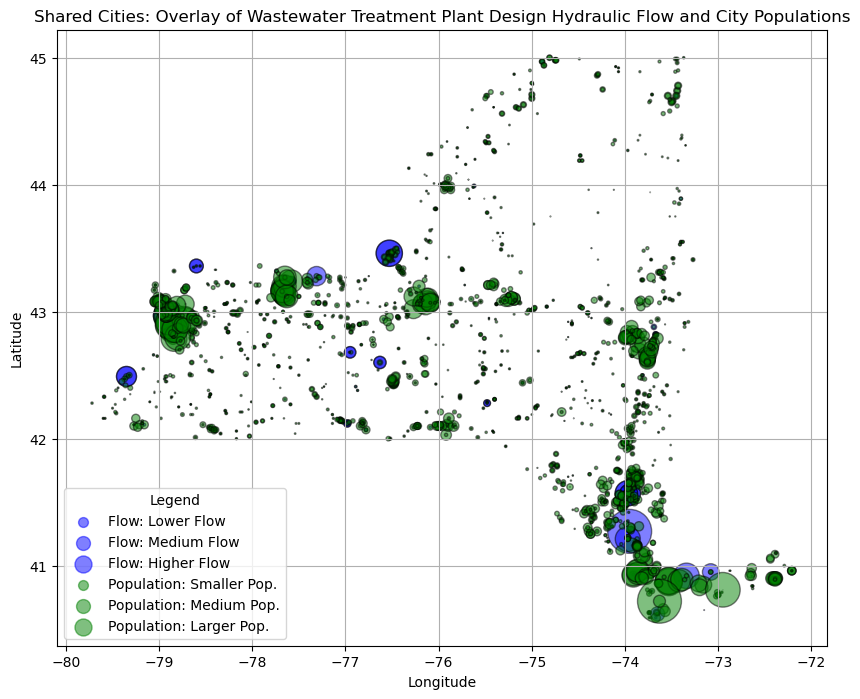

In [40]:
# Set size factors based on normalized population and hydraulic flow
flow_size_factor = 1000  # Adjust this factor to scale normalized wastewater treatment marker sizes
pop_size_factor = 1000  # Adjust this factor to scale normalized population marker sizes

# Create marker sizes for the merged DataFrame using normalized columns
merged_df['Flow Marker Size'] = merged_df['Normalized Average Design Hydraulic Flow'] * flow_size_factor
merged_df['Pop Marker Size'] = merged_df['Normalized Population'] * pop_size_factor

# Create a GeoDataFrame for the merged data
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Plot the figure
plt.figure(figsize=(10, 8))

# Plot the wastewater treatment plants with marker size based on normalized hydraulic flow
merged_gdf.plot(
    ax=plt.gca(),
    color='blue', 
    markersize=merged_df['Flow Marker Size'], 
    alpha=0.5, 
    edgecolor='k',
)

# Plot the city populations with marker size based on normalized population
merged_gdf.plot(
    ax=plt.gca(),
    color='green', 
    markersize=merged_df['Pop Marker Size'], 
    alpha=0.5, 
    edgecolor='k',
)

# Add title and labels
plt.title('Shared Cities: Overlay of Wastewater Treatment Plant Design Hydraulic Flow and City Populations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

# Create a unified legend size scale for both datasets
# Choose a size range for the legend
legend_marker_sizes = [50000, 100000, 150000]  # Adjust size for visual purposes

# Create a custom legend for both
# Wastewater Treatment Plants Legend
labels_flow = ['Lower Flow', 'Medium Flow', 'Higher Flow']
for size, label in zip(legend_marker_sizes, labels_flow):
    plt.scatter([], [], s=size / flow_size_factor, color='blue', alpha=0.5, label=f'Flow: {label}')

# City Population Legend
labels_pop = ['Smaller Pop.', 'Medium Pop.', 'Larger Pop.']
for size, label in zip(legend_marker_sizes, labels_pop):
    plt.scatter([], [], s=size / pop_size_factor, color='green', alpha=0.5, label=f'Population: {label}')

# Add a unified legend
plt.legend(title="Legend", loc="lower left")

# Show the plot
plt.show()


In [53]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [54]:
import plotly.express as px

# Create a scatter mapbox
fig = px.scatter_mapbox(
    merged_df,
    lat='lat',
    lon='lng',
    size='Flow Marker Size',  # For wastewater treatment plants
    color_discrete_sequence=['blue'],
    hover_name='City',
    hover_data={'Average Design Hydraulic Flow': True, 'population': False},
    title='Wastewater Treatment Plant Flow Rates and City Populations',
    template='plotly'
)

# Add city populations
fig.add_trace(px.scatter_mapbox(
    merged_df,
    lat='lat',
    lon='lng',
    size='Pop Marker Size',  # For city populations
    color_discrete_sequence=['green'],
    hover_name='City',
    hover_data={'population': True, 'Average Design Hydraulic Flow': False}
).data[0])

# Update layout to enable zoom
fig.update_layout(mapbox_style='open-street-map', mapbox_zoom=8, mapbox_center_lat=merged_df['lat'].mean(), mapbox_center_lon=merged_df['lng'].mean())

# Show the figure
fig.show()


<b>Conclusion:</b> In this analysis, we have discovered that average hydraulic flow rates are typically higher around high population areas. But what can also be seen are some potential problem areas, as seen above. Note that there are some high flow rate areas with small populations, and vice versa. These could use some investigation. For example, from an efficiency perspective, could it be problematic that low population areas are having high flow rates? Areas with significant differences between population and flow rates warrant further investigation to ensure the infrastructure is adequately designed to meet current and future needs while maintaining efficiency and regulatory compliance.